In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Task 1
Apply Sequential Importance Sampling (SIS) for the synthetic time varying AR problem in the Kalman Filter Assignment. Show that sequential impor- tance sampling suffers from weight degeneracy. Implement a particle filter on the synthetic time varying AR problem by extending SIS to include a resampling step. Investigate the impact of resampling on the importance weights. Compare your results to Kalman filter solution and discuss your findings.

## State Space Model
$\theta (n) = \theta (n-1) + w(n)\\
y(n) = \theta^T x_n + v(n)$

In [105]:
from pf import PF

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from numpy.random import default_rng
seed = 42
rng = default_rng(seed=seed)

In [142]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 10,
    # # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

Text(0.5, 1.0, 'Time Varying Autoregressive Process')

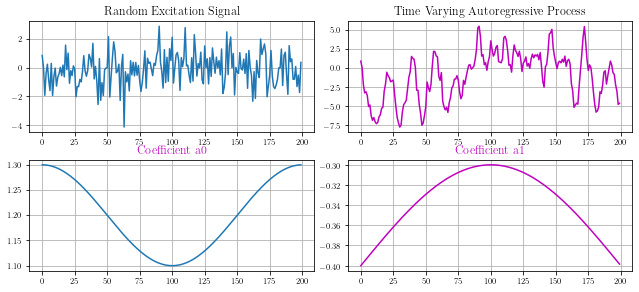

In [107]:
# Length of time series
#
N=200
# Gaussian random numbers as an excitation signal
#
ex = np.random.randn(N)
# Second order AR Process with coefficients slowly changing in time
#

a0 = np.array([1.2, -0.4])
A  = np.zeros((N,2))
omega, alpha = N/2, 0.1
for n in range(N):
    A[n,0] = a0[0] + (alpha * np.cos(2*np.pi*n/N))
    A[n,1] = a0[1] + (alpha * np.sin(np.pi*n/N))
S = ex.copy()
for n in range(2, N):
    x = np.array([S[n-1], S[n-2]])
    S[n] = np.dot(x, A[n,:]) + ex[n]

# a = np.array([1.2, -0.4])
# S = ex.copy()
# for n in range(2, N):
#     x = np.array([S[n-1], S[n-2]])
#     S[n] = np.dot(x, a) + ex[n]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,4))
plt.tight_layout()
ax[1,0].plot(range(N), A[:,0])
ax[1,0].grid(True)
ax[1,0].set_title("Coefficient a0", color='m')
ax[1,1].plot(range(N), A[:,1], color='m')
ax[1,1].grid(True)
ax[1,1].set_title("Coefficient a1", color='m')
ax[0,0].plot(range(N), ex)
ax[0,0].grid(True)
ax[0,0].set_title("Random Excitation Signal")
ax[0,1].plot(range(N), S, color='m')
ax[0,1].grid(True)
ax[0,1].set_title("Time Varying Autoregressive Process")

In [108]:
# fig.savefig("report/Figures/arChange.png")

## Initialisation

In [147]:
# theta0 = np.random.rand(2)
theta0 = np.array([1.2, -0.4])
P0 = 0.001 * np.eye(2)
beta = 0.01
Q = beta * np.eye(2) # process noise
R = np.var(ex) # observation noise

Ns = 1000

## Kalman Filter

In [148]:
from pf import KF

In [149]:
theta_kf, error_kf = KF(S, theta0, P0, Q, R)

## Sequential Importance Sampling (SIS) Algorithm

In [150]:
theta_sis, weights_sis, error_sis, ess_sis = PF(S, theta0, Q, R, Ns, resample=False)

100%|██████████| 198/198 [00:39<00:00,  5.02it/s]


In [151]:
theta_sis_expected = np.sum(weights_sis[:, :, np.newaxis] * theta_sis, axis=1)

### Particle Weights Plot

Plot of particle index against time index, where the marker size scales with the size of the weights.

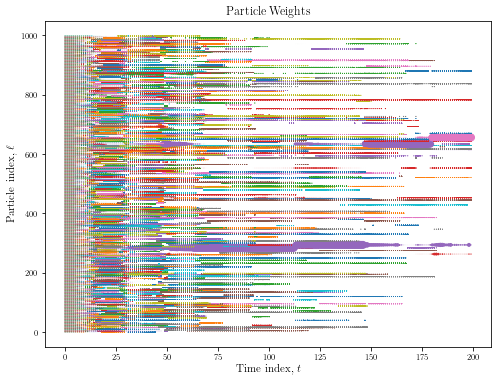

In [152]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(title='Particle Weights', xlabel='Time index, $t$', ylabel='Particle index, $\ell$')
for i in range(Ns):
    ax.scatter(range(N), [i]*N, s=(50*weights_sis[:, i]))

In [153]:
# fig.savefig('report/Figures/particle_weights_sis.pdf')

## Sequential Importance Resampling (SIR) Algorithm

In [154]:
theta_sir, weights_sir, error_sir, ess_sir = PF(S, theta0, Q, R, Ns, resample=True)

100%|██████████| 198/198 [00:38<00:00,  5.13it/s]


In [155]:
theta_sir_expected = np.sum(weights_sir[:, :, np.newaxis] * theta_sir, axis=1)

### Particle Weights Plot

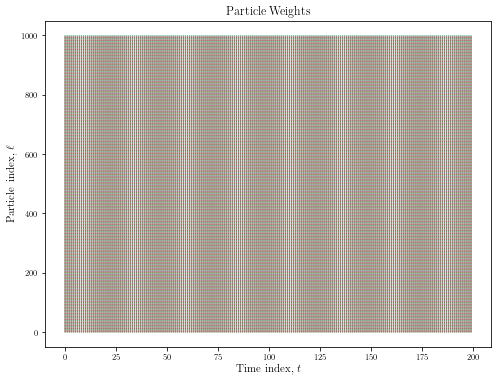

In [156]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(title='Particle Weights', xlabel='Time index, $t$', ylabel='Particle index, $\ell$')
for i in range(Ns):
    ax.scatter(range(N), [i]*N, s=(50*weights_sir[:, i]))

In [146]:
# fig.savefig('report/Figures/particle_weights_sir.pdf')

## Theta Plots

Coefficient a0

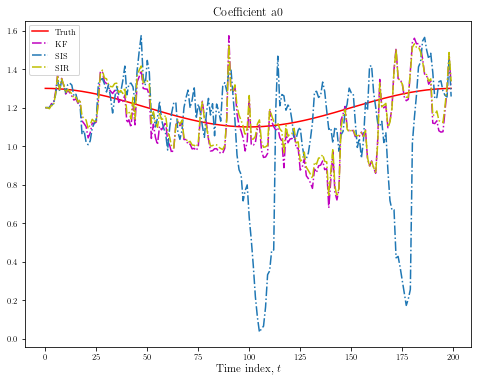

In [157]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(title='Coefficient a0', xlabel='Time index, $t$')
ax.plot(A[:, 0], color='red', label='Truth')
ax.plot(theta_kf[0], linestyle='-.', label='KF', color='m')
ax.plot(theta_sis_expected[:, 0], linestyle='-.', label='SIS')
ax.plot(theta_sir_expected[:, 0], linestyle='-.', label='SIR', color='y')
ax.legend()

In [158]:
# fig.savefig('report/Figures/coefficient_a0.pdf')

Coefficient a1

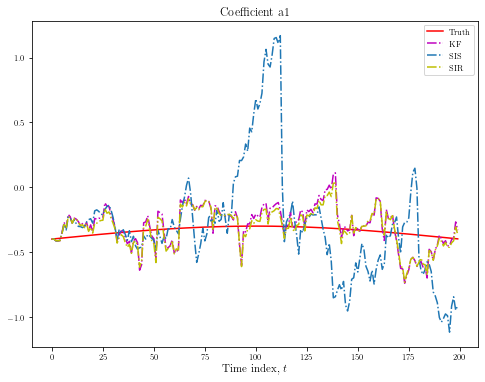

In [159]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(title='Coefficient a1', xlabel='Time index, $t$')
ax.plot(A[:, 1], color='red', label='Truth')
ax.plot(theta_kf[1], linestyle='-.', label='KF', color='m')
ax.plot(theta_sis_expected[:, 1], linestyle='-.', label='SIS')
ax.plot(theta_sir_expected[:, 1], linestyle='-.', label='SIR', color='y')
ax.legend()

In [160]:
# fig.savefig('report/Figures/coefficient_a1.pdf')

## Error Plots

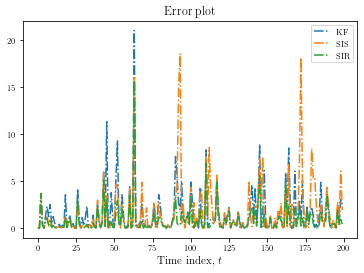

In [165]:
fig, ax = plt.subplots()
ax.set(title='Error plot', xlabel='Time index, $t$')
ax.plot(error_kf, linestyle='-.', label='KF')
ax.plot(error_sis, linestyle='-.', label='SIS')
ax.plot(error_sir, linestyle='-.', label='SIR')
ax.legend()

In [166]:
# fig.savefig('report/Figures/error.pdf')

## MSE

In [167]:
error_kf.mean()

1.5616583449026071

In [168]:
error_sis.mean()

1.6764133445261458

In [169]:
error_sir.mean()

0.8353866300876922

## Effective Sample Size (ESS)

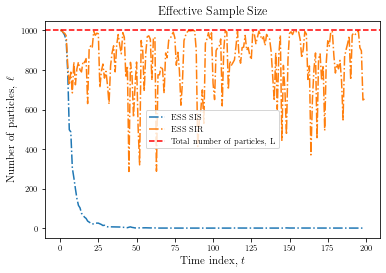

In [163]:
fig, ax = plt.subplots()
ax.set(title='Effective Sample Size', xlabel='Time index, $t$', ylabel='Number of particles, $\ell$')
ax.plot(ess_sis, label='ESS SIS', linestyle='-.')
ax.plot(ess_sir, label='ESS SIR', linestyle='-.')
ax.axhline(Ns, color='r', linestyle='--', label='Total number of particles, L')
ax.legend()

In [164]:
# fig.savefig('report/Figures/ess.pdf')